In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import os
import seaborn as sns
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import categorical_crossentropy
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization, Flatten
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model, load_model, Sequential
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import save_model
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.preprocessing import image

In [2]:
sdir=r'C:\Users\asus\Bayu\Training\ML\DaunJagung'

filepaths=[]
labels=[]
classlist=os.listdir(sdir)
for klass in classlist:
    classpath=os.path.join(sdir,klass)
    if os.path.isdir(classpath):
        flist=os.listdir(classpath)
        for f in flist:
            fpath=os.path.join(classpath,f)
            filepaths.append(fpath)
            labels.append(klass)
Fseries= pd.Series(filepaths, name='filepaths')
Lseries=pd.Series(labels, name='labels')
df=pd.concat([Fseries, Lseries], axis=1)
print (df.head())
print (df['labels'].value_counts())

                                           filepaths       labels
0  C:\Users\asus\Bayu\Training\ML\DaunJagung\Berc...  Bercak Daun
1  C:\Users\asus\Bayu\Training\ML\DaunJagung\Berc...  Bercak Daun
2  C:\Users\asus\Bayu\Training\ML\DaunJagung\Berc...  Bercak Daun
3  C:\Users\asus\Bayu\Training\ML\DaunJagung\Berc...  Bercak Daun
4  C:\Users\asus\Bayu\Training\ML\DaunJagung\Berc...  Bercak Daun
labels
Bercak Daun    1000
Daun Sehat     1000
Hawar Daun     1000
Karat Daun     1000
Name: count, dtype: int64


In [3]:
train_split=.8
test_split=.1
dummy_split=test_split/(1-train_split)
train_df, dummy_df=train_test_split(df, train_size=train_split, shuffle=True, random_state=123)
test_df, valid_df=train_test_split(dummy_df, train_size=dummy_split, shuffle=True, random_state=123)
print ('train_df length: ', len(train_df), '  test_df length: ', len(test_df), '  valid_df length: ', len(valid_df))

train_df length:  3200   test_df length:  400   valid_df length:  400


In [4]:
# Definisikan ukuran gambar dan batch size
height = 224
width = 224
channels = 3
batch_size = 64

img_shape = (height, width, channels)
img_size = (height, width)

# Hitung ukuran batch untuk data pengujian
length = len(test_df)
test_batch_size = sorted([int(length/n) for n in range(1, length+1) if length % n == 0 and length/n <= 80], reverse=True)[0]
test_steps = int(length/test_batch_size)
print('Test batch size:', test_batch_size, ' Test steps:', test_steps)

# Normalisasi dan augmentasi data
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalisasi nilai piksel
    rotation_range=20,  # Rotasi hingga 20 derajat
    width_shift_range=0.1,  # Pergeseran lebar maksimum 10%
    height_shift_range=0.1,  # Pergeseran tinggi maksimum 10%
    shear_range=0.2,  # Pergeseran sudut maksimum 20 derajat
    zoom_range=0.2,  # Zoom maksimum 20%
    horizontal_flip=True  # Flipping horizontal
)

# Normalisasi data pengujian dan validasi
test_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)

# Flow dari DataFrame
train_gen = train_datagen.flow_from_dataframe(
    train_df,
    x_col='filepaths',
    y_col='labels',
    target_size=img_size,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=True,
    batch_size=batch_size
)

valid_gen = valid_datagen.flow_from_dataframe(
    valid_df,
    x_col='filepaths',
    y_col='labels',
    target_size=img_size,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=True,
    batch_size=batch_size
)

test_gen = test_datagen.flow_from_dataframe(
    test_df,
    x_col='filepaths',
    y_col='labels',
    target_size=img_size,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=False,
    batch_size=test_batch_size
)

# Daftar kelas
classes = list(train_gen.class_indices.keys())
print(classes)
class_count = len(classes)

Test batch size: 80  Test steps: 5
Found 3200 validated image filenames belonging to 4 classes.
Found 400 validated image filenames belonging to 4 classes.
Found 400 validated image filenames belonging to 4 classes.
['Bercak Daun', 'Daun Sehat', 'Hawar Daun', 'Karat Daun']


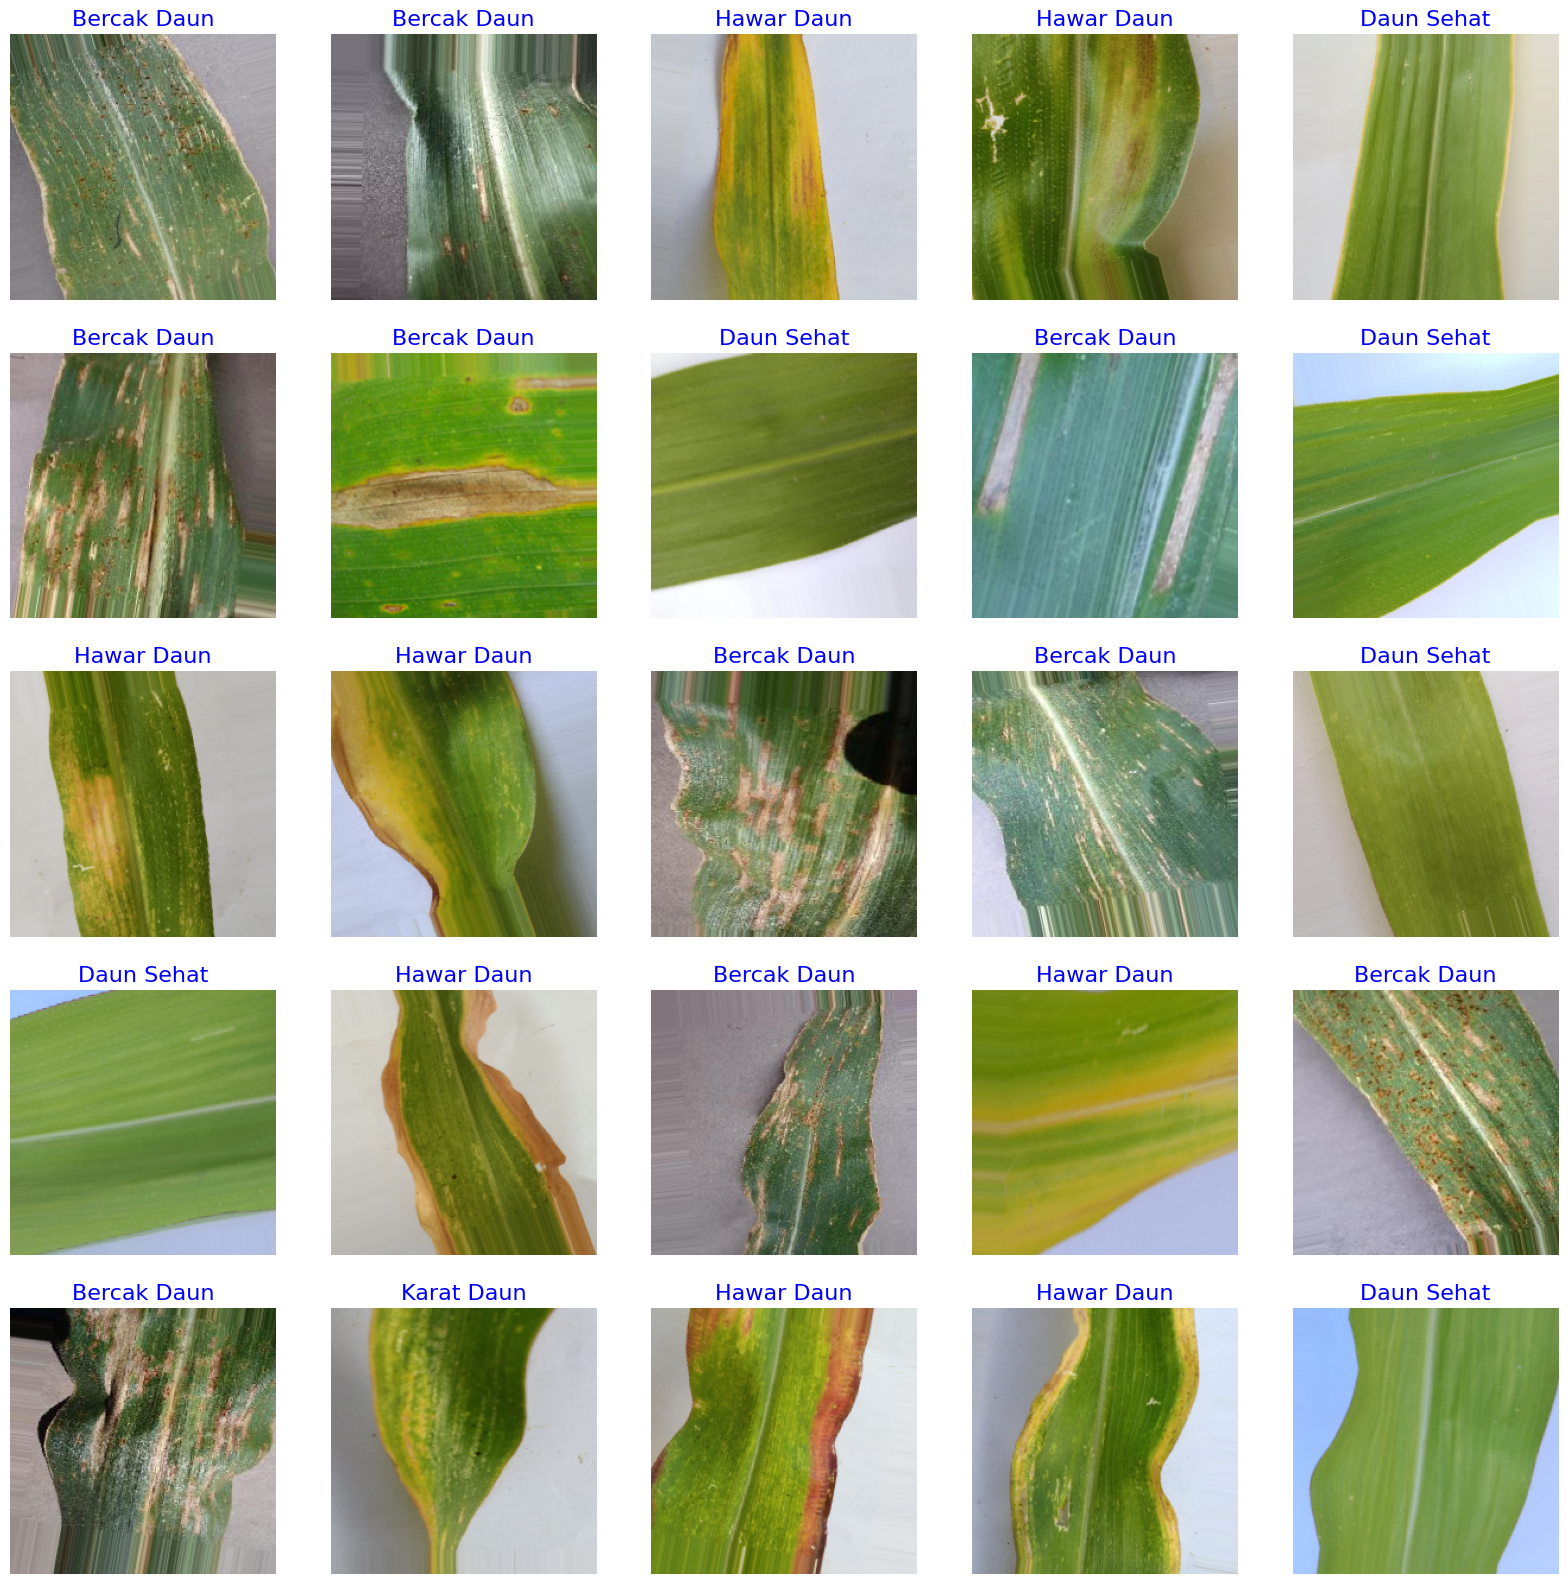

In [5]:
def show_image_samples(gen):
    test_dict=test_gen.class_indices
    classes=list(test_dict.keys())
    images,labels=next(gen)
    plt.figure(figsize=(20, 20))
    length=len(labels)
    if length<25:
        r=length
    else:
        r=25
    for i in range(r):
        plt.subplot(5, 5, i + 1)
        image=images[i]
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=classes[index]
        plt.title(class_name, color='blue', fontsize=16)
        plt.axis('off')
    plt.show()

show_image_samples(train_gen)

In [7]:
base_model = tf.keras.applications.DenseNet201(
    include_top=False,
    weights='imagenet',
    input_tensor=Input(shape=(224,224,3)),
)



74836368/74836368 [==============================] - 5s 0us/step


In [8]:
base_model.summary()

Model: "densenet201"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 zero_padding2d (ZeroPaddin  (None, 230, 230, 3)          0         ['input_1[0][0]']             
 g2D)                                                                                             
                                                                                                  
 conv1/conv (Conv2D)         (None, 112, 112, 64)         9408      ['zero_padding2d[0][0]']      
                                                                                                  
 conv1/bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1/conv[0][0]']

In [9]:
base_model.trainable = False

In [10]:
Model_name='Projek DM'
print("Building model with", base_model)
model = tf.keras.Sequential([
            base_model,
            tf.keras.layers.Conv2D(filters=32, padding='same', kernel_size=3, activation='relu', strides=1),
            tf.keras.layers.MaxPool2D(pool_size=2, strides=2),
            tf.keras.layers.Dropout(rate=0.5),

            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(4, activation='softmax')
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=.001), loss='categorical_crossentropy', metrics='accuracy')

Building model with <keras.src.engine.functional.Functional object at 0x00000253DCA50100>


In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet201 (Functional)    (None, 7, 7, 1920)        18321984  
                                                                 
 conv2d (Conv2D)             (None, 7, 7, 32)          552992    
                                                                 
 max_pooling2d (MaxPooling2  (None, 3, 3, 32)          0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 3, 3, 32)          0         
                                                                 
 flatten (Flatten)           (None, 288)               0         
                                                                 
 dense (Dense)               (None, 4)                 1156      
                                                        

In [12]:
epochs =12

history=model.fit(x=train_gen, epochs=epochs, validation_data=valid_gen)

Epoch 1/12


50/50 [==============================] - 343s 7s/step - loss: 1.0014 - accuracy: 0.6009 - val_loss: 0.4216 - val_accuracy: 0.8700
Epoch 2/12
50/50 [==============================] - 323s 6s/step - loss: 0.4033 - accuracy: 0.8447 - val_loss: 0.1973 - val_accuracy: 0.9350
Epoch 3/12
50/50 [==============================] - 324s 6s/step - loss: 0.2572 - accuracy: 0.9153 - val_loss: 0.2091 - val_accuracy: 0.9400
Epoch 4/12
50/50 [==============================] - 331s 7s/step - loss: 0.2230 - accuracy: 0.9234 - val_loss: 0.1432 - val_accuracy: 0.9375
Epoch 5/12
50/50 [==============================] - 354s 7s/step - loss: 0.1763 - accuracy: 0.9419 - val_loss: 0.1052 - val_accuracy: 0.9625
Epoch 6/12
50/50 [==============================] - 324s 6s/step - loss: 0.1722 - accuracy: 0.9422 - val_loss: 0.1089 - val_accuracy: 0.9550
Epoch 7/12
50/50 [==============================] - 331s 7s/step - loss: 0.1686 - accuracy: 0.9466 - val_loss: 0.1244 - val_accuracy: 0.9525
Epoch 8/12


In [13]:
def print_in_color(txt_msg,fore_tupple,back_tupple,):
    rf,gf,bf=fore_tupple
    rb,gb,bb=back_tupple
    msg='{0}' + txt_msg
    mat='\33[38;2;' + str(rf) +';' + str(gf) + ';' + str(bf) + ';48;2;' + str(rb) + ';' +str(gb) + ';' + str(bb) +'m'
    print(msg .format(mat), flush=True)
    print('\33[0m', flush=True)
    return

In [14]:
def tr_plot(tr_data, start_epoch=1):
    tacc = tr_data.history['accuracy']
    tloss = tr_data.history['loss']
    vacc = tr_data.history['val_accuracy']
    vloss = tr_data.history['val_loss']
    Epoch_count = len(tacc) + start_epoch
    Epochs = list(range(start_epoch, Epoch_count))
    index_loss = np.argmin(vloss)
    val_lowest = vloss[index_loss]
    index_acc = np.argmax(vacc)
    acc_highest = vacc[index_acc]

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))


    axes[0].plot(Epochs, tloss, 'r', label='Training loss')
    axes[0].plot(Epochs, vloss, 'g', label='Validation loss')
    axes[0].scatter(index_loss + start_epoch, val_lowest, s=150, c='blue', label=f'Best epoch = {index_loss + start_epoch}')
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()

    axes[1].plot(Epochs, tacc, 'r', label='Training Accuracy')
    axes[1].plot(Epochs, vacc, 'g', label='Validation Accuracy')
    axes[1].scatter(index_acc + start_epoch, acc_highest, s=150, c='blue', label=f'Best epoch = {index_acc + start_epoch}')
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()

    plt.tight_layout()
    plt.show()


In [15]:
def print_info( test_gen, preds, print_code, save_dir, subject ):
    class_dict=test_gen.class_indices
    labels= test_gen.labels
    file_names= test_gen.filenames
    error_list=[]
    true_class=[]
    pred_class=[]
    prob_list=[]
    new_dict={}
    error_indices=[]
    y_pred=[]
    for key,value in class_dict.items():
        new_dict[value]=key
    classes=list(new_dict.values())
    dict_as_text=str(new_dict)
    dict_name= subject + '-' +str(len(classes)) +'.txt'
    dict_path=os.path.join(save_dir,dict_name)
    with open(dict_path, 'w') as x_file:
        x_file.write(dict_as_text)
    errors=0
    for i, p in enumerate(preds):
        pred_index=np.argmax(p)
        true_index=labels[i]
        if pred_index != true_index:
            error_list.append(file_names[i])
            true_class.append(new_dict[true_index])
            pred_class.append(new_dict[pred_index])
            prob_list.append(p[pred_index])
            error_indices.append(true_index)
            errors=errors + 1
        y_pred.append(pred_index)
    if print_code !=0:
        if errors>0:
            if print_code>errors:
                r=errors
            else:
                r=print_code
            msg='{0:^28s}{1:^28s}{2:^28s}{3:^16s}'.format('Filename', 'Predicted Class' , 'True Class', 'Probability')
            print_in_color(msg, (0,255,0),(55,65,80))
            for i in range(r):
                split1=os.path.split(error_list[i])
                split2=os.path.split(split1[0])
                fname=split2[1] + '/' + split1[1]
                msg='{0:^28s}{1:^28s}{2:^28s}{3:4s}{4:^6.4f}'.format(fname, pred_class[i],true_class[i], ' ', prob_list[i])
                print_in_color(msg, (255,255,255), (55,65,60))
        else:
            msg='With accuracy of 100 % there are no errors to print'
            print_in_color(msg, (0,255,0),(55,65,80))
    if errors>0:
        plot_bar=[]
        plot_class=[]
        for  key, value in new_dict.items():
            count=error_indices.count(key)
            if count!=0:
                plot_bar.append(count)
                plot_class.append(value)
        fig=plt.figure()
        fig.set_figheight(len(plot_class)/3)
        fig.set_figwidth(10)
        plt.style.use('fivethirtyeight')
        for i in range(0, len(plot_class)):
            c=plot_class[i]
            x=plot_bar[i]
            plt.barh(c, x, )
            plt.title( ' Errors by Class on Test Set')
    y_true= np.array(labels)
    y_pred=np.array(y_pred)
    if len(classes)<= 30:
        cm = confusion_matrix(y_true, y_pred )
        length=len(classes)
        if length<8:
            fig_width=8
            fig_height=8
        else:
            fig_width= int(length * .5)
            fig_height= int(length * .5)
        plt.figure(figsize=(fig_width, fig_height))
        sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)
        plt.xticks(np.arange(length)+.5, classes, rotation= 90)
        plt.yticks(np.arange(length)+.5, classes, rotation=0)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()
    clr = classification_report(y_true, y_pred, target_names=classes)
    print("Classification Report:\n----------------------\n", clr)

In [16]:
num_classes = model.layers[-1].output_shape[1]
print("Number of classes:", num_classes)

Number of classes: 4


5/5 [==============================] - 34s 6s/step - loss: 0.1778 - accuracy: 0.9575


C:\Users\asus\AppData\Local\Temp\ipykernel_18356\1799171802.py:8: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  save_model(model, save_loc)


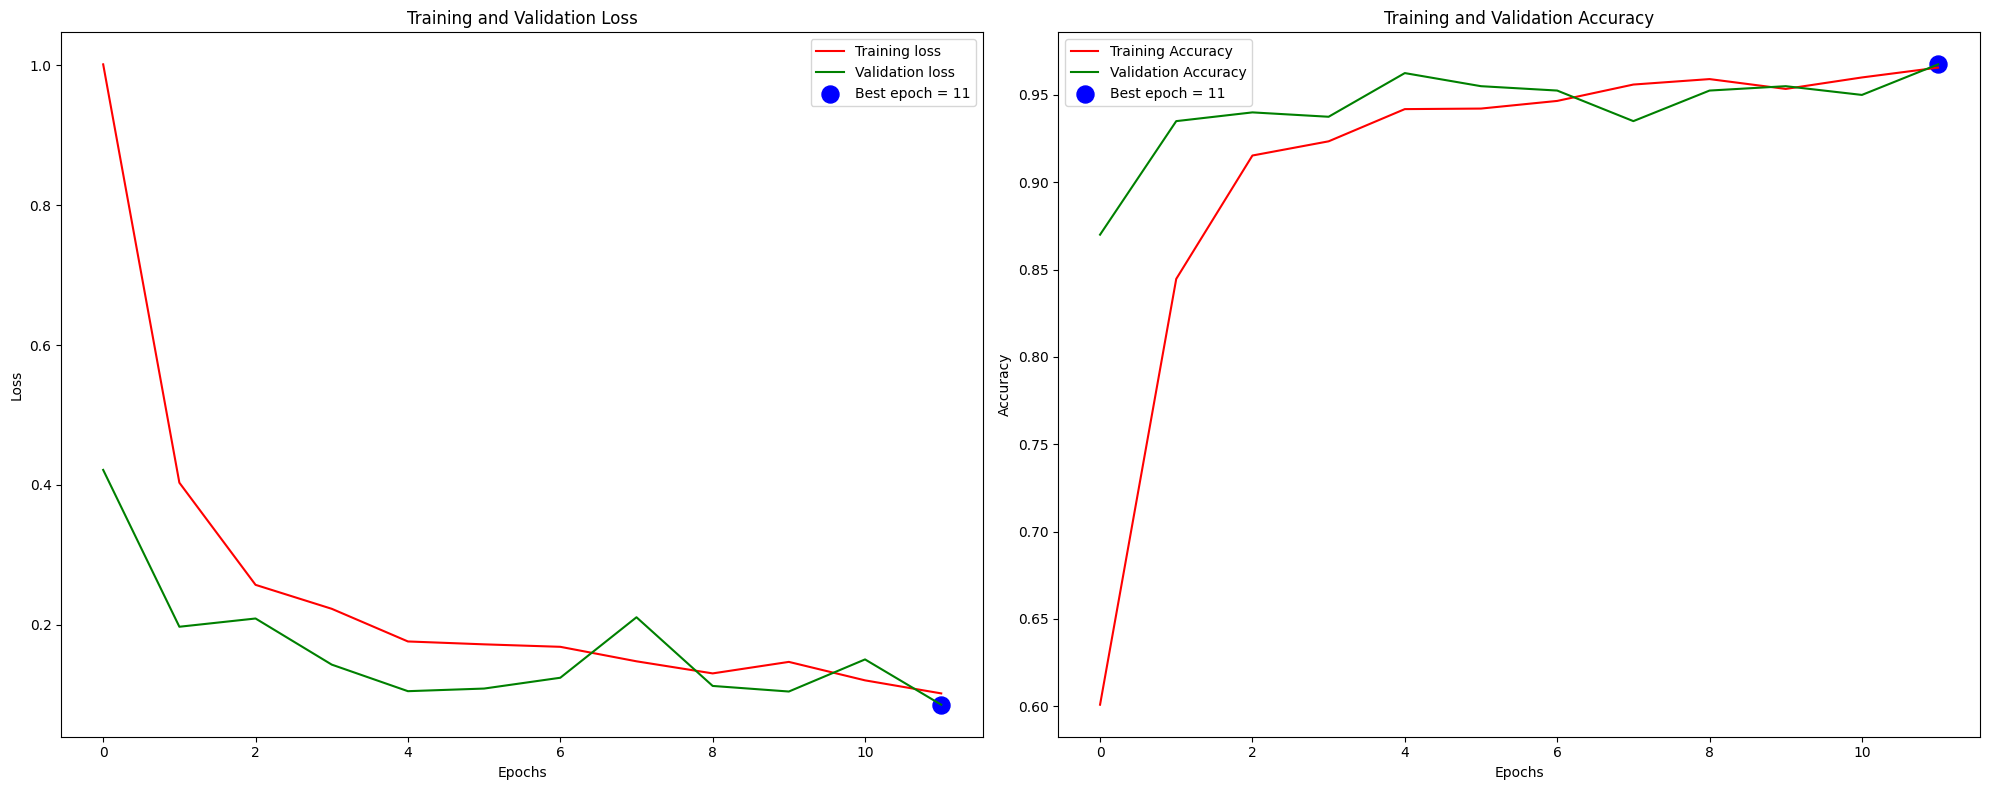

Accuracy on the test set is 95.75 %



In [19]:
save_dir = r'C:\Users\asus\Bayu\Training\ML'
acc = model.evaluate(test_gen, batch_size=test_batch_size, verbose=1, steps=test_steps, return_dict=False)[1] * 100

model_name = "dense_model"
save_id = f'{model_name}.h5'
save_loc = os.path.join(save_dir, save_id)

save_model(model, save_loc)

tr_plot(history,0)
msg = f'Accuracy on the test set is {acc:5.2f} %'
print_in_color(msg, (0, 255, 0), (55, 65, 80))

5/5 [==============================] - 39s 7s/step


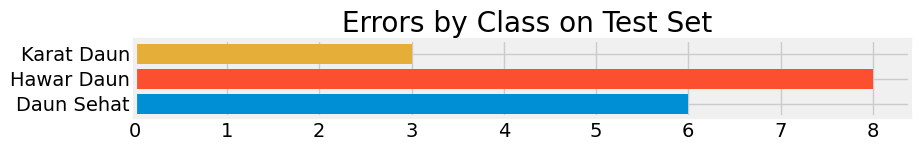

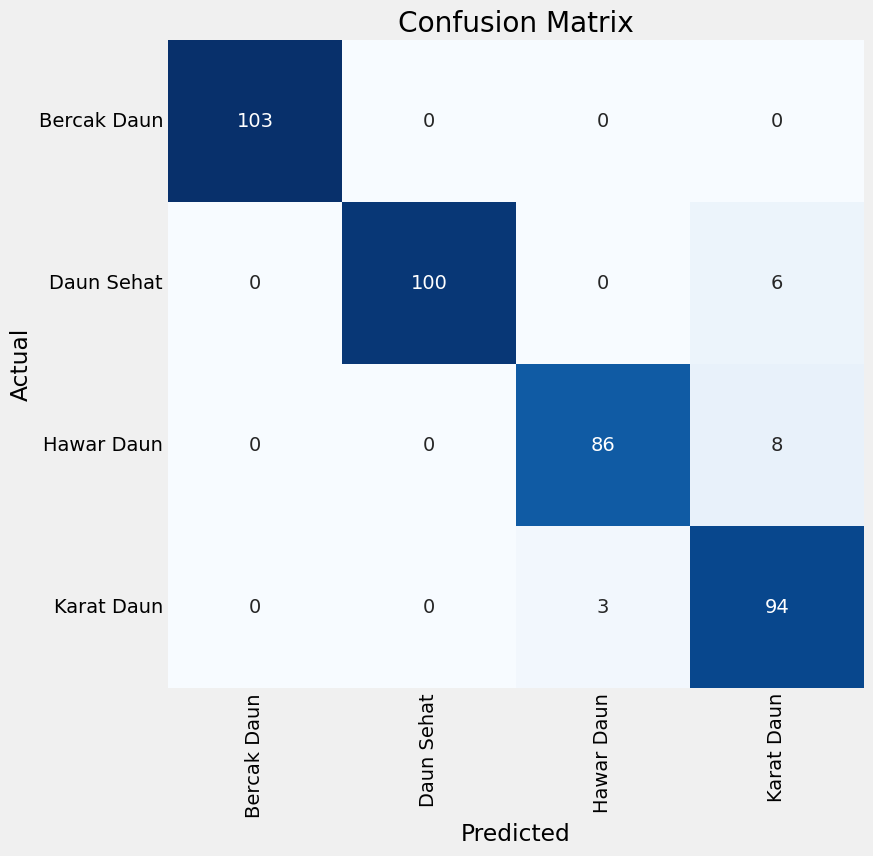

Classification Report:
----------------------
               precision    recall  f1-score   support

 Bercak Daun       1.00      1.00      1.00       103
  Daun Sehat       1.00      0.94      0.97       106
  Hawar Daun       0.97      0.91      0.94        94
  Karat Daun       0.87      0.97      0.92        97

    accuracy                           0.96       400
   macro avg       0.96      0.96      0.96       400
weighted avg       0.96      0.96      0.96       400



In [20]:
subject = "pest"

print_code=0
preds=model.predict(test_gen)
print_info( test_gen, preds, print_code, save_dir, subject )

In [21]:
image_path = r"C:\Users\asus\Bayu\Training\ML\Testing\daun sehat.jpg"

img = image.load_img(image_path, target_size=(height, width))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)

img_array /= 255.0

predictions = model.predict(img_array)

predicted_class = np.argmax(predictions[0])

print("Predicted class:", classes[predicted_class])

1/1 [==============================] - 3s 3s/step
Predicted class: Daun Sehat


1/1 [==============================] - 3s 3s/step


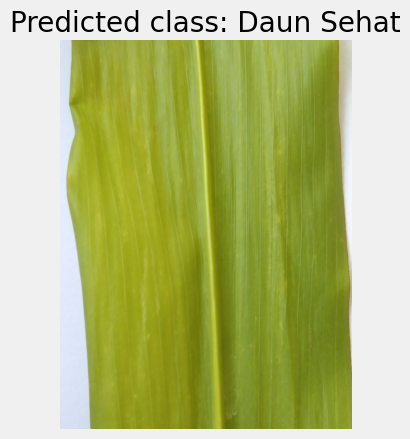

In [24]:
# Path gambar
image_path = r"C:\Users\asus\Bayu\Training\ML\Testing\daun sehat.jpg"

# Dimensi target gambar
height, width = 224, 224  # Ubah sesuai dengan dimensi input model Anda

# Load dan preprocess gambar
img = image.load_img(image_path, target_size=(height, width))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.0

# Prediksi menggunakan model
model = load_model(r"C:\Users\asus\Bayu\Training\ML\dense_model.h5")  # Ganti dengan path model Anda
predictions = model.predict(img_array)
predicted_class = np.argmax(predictions[0])

# Daftar kelas
classes = ['Bercak Daun', 'Daun Sehat', 'Hawar Daun', 'Karat Daun']  # Ganti dengan kelas-kelas sebenarnya

# Menampilkan gambar dengan prediksi
plt.imshow(image.load_img(image_path))
plt.title(f'Predicted class: {classes[predicted_class]}')
plt.axis('off')  # Menghilangkan axis
plt.show()
